In [1]:
import pandas as pd

from extract_transform import get_sorted_ngram_counts
from visualize import plot_wordcloud, plot_ngram_counts

In [2]:
osm_data = pd.read_json('data/preprocessed_osm_data.json.gz')
wikidata = pd.read_json('data/preprocessed_wikidata.json')

In [3]:
wikidata.head(5)

,qid,preprocessed_names,preprocessed_description
0,Q37158,starbucks starbucks corporation starbucks coff...,american multinational coffee company
1,Q154950,royal dutch shell rds shell royal dutch shell plc,anglo dutch oil company
2,Q1208279,petro canada,company
3,Q867662,esso exxcon,oil gas company
4,Q175106,tim hortons tim hortons inc,multinational quick service restaurant chain


In [4]:
names = wikidata['preprocessed_names']
descriptions = wikidata['preprocessed_description']

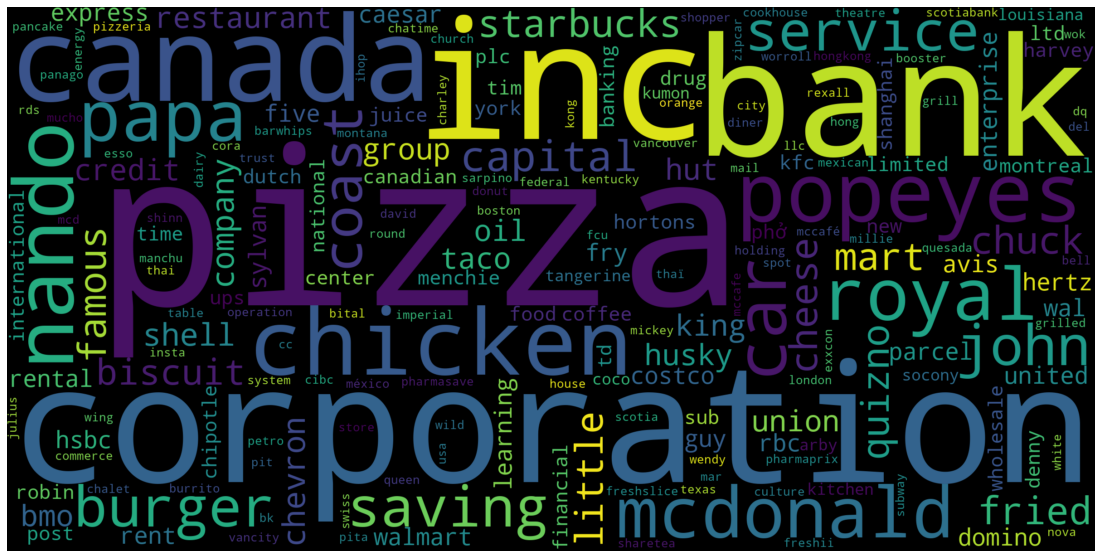

In [5]:
name_text = ' '.join(names)
plot_wordcloud(name_text)

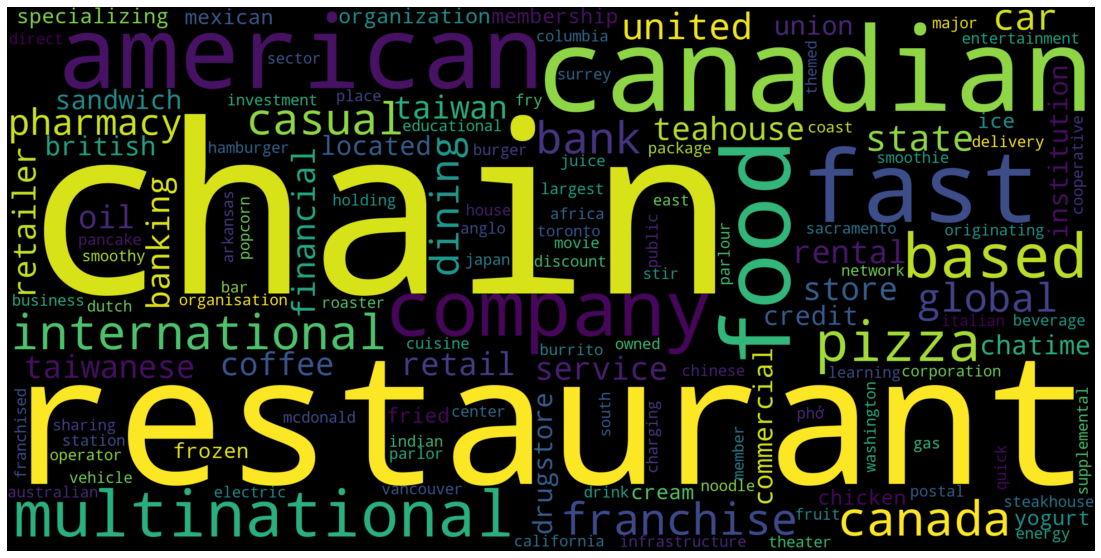

In [6]:
description_text = ' '.join(descriptions)
plot_wordcloud(description_text)

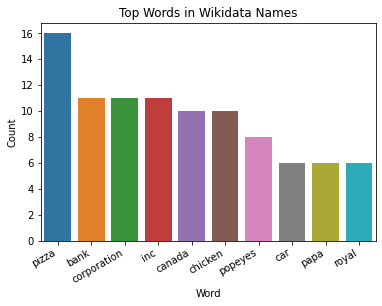

In [7]:
name_word_counts = get_sorted_ngram_counts(names)
plot_ngram_counts(name_word_counts, 'Top Words in Wikidata Names', 'Word')

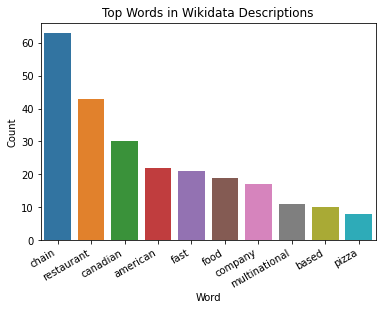

In [8]:
description_word_counts = get_sorted_ngram_counts(descriptions)
plot_ngram_counts(description_word_counts, 'Top Words in Wikidata Descriptions', 'Word')

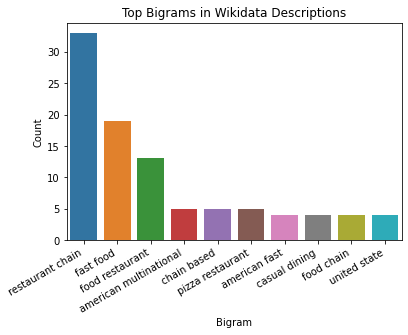

In [10]:
description_word_counts = get_sorted_ngram_counts(descriptions, ngram_range=(2, 2))
plot_ngram_counts(description_word_counts, 'Top Bigrams in Wikidata Descriptions', 'Bigram')